<a href="https://colab.research.google.com/github/Jaesu26/aifactory-water-demand-forecasting/blob/main/2022-12-08-%EB%86%8D%EC%B4%8C%EC%A7%80%EC%97%AD-%EC%88%98%EB%8F%97%EB%AC%BC-%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [2022 제2회 K-water AI 경진대회] 수돗물 수요예측 AI 알고리즘 개발

- [2022-Task 2] 아포 : 경상북도 김천시 아포읍

In [26]:
import platform

In [27]:
platform.platform()

'Linux-5.10.133+-x86_64-with-glibc2.27'

In [28]:
!cat /etc/issue.net

Ubuntu 18.04.6 LTS


In [29]:
!python --version

Python 3.8.15


In [25]:
!nvidia-smi

Thu Dec  8 12:18:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

런타임 유형: GPU

Linux-5.10.133+-x86_64-with-glibc2.27

Ubuntu 18.04.6 LTS

Python 3.8.15

GPU: NVIDIA-SMI 460.32.03

Driver Version: 460.32.03 

CUDA Version: 11.2

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import random
import math
import os
import gc

import statsmodels.graphics.tsaplots as sgt

from typing import List, Optional, Tuple, Union
from numpy.typing import NDArray
from easydict import EasyDict

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore') 

In [2]:
from google.colab import drive

drive.mount('/content/drive')  # 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd  /content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측

/content/drive/MyDrive/Colab Notebooks/농촌지역-수돗물-수요예측


- 데이터 불러오기

In [4]:
train_path = './data/data_tr_apo.csv'
test_path = './data/data_ts_apo.csv'
submission_path = './data/sample_apo.csv'

In [5]:
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [6]:
# 변수 이름을 영문으로 변경
df = df.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})
test = test.rename(columns={'구미 아포배수지 유출유량 적산차':'flow'})


# 날짜를 datetime 형식으로 변경
df['datetime'] = pd.to_datetime(df['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
submission['datetime'] = pd.to_datetime(submission['datetime'])

In [7]:
test2 = test.copy()

- 가중치 저장폴더

In [8]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

- 데이터 설명

`-` 유량: 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타냄 ($m^3/h$)

`-` 적산값: 1시간마다 측정한 값이 계속 누적 (i.g. $100 \xrightarrow{~+170~} 270 \xrightarrow{~+150~} 420 \xrightarrow{~+110~} 530$)  

`-` 적산차값: 적산의 매시간 차이를 계산 ($\approx$ 시간 단위 공급량,$\quad$ i.g. $\operatorname{NA},170, 150, 110$)

## 전처리

`-` 데이터는 항상 시간상의 순서대로 존재해야 한다

`-` 데이터에서 특정 시점의 적산차값이 결측치일 수도 있지만 특정 시점 자체가 누락되면 안된다 

`-` 그래프에 추세는 없어보인다

`-` 데이터에 결측치가 존재한다

`-` 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채워주자

`-` 이상치가 존재한다 (예컨대 음수 또는 매우 큰 양수)

`-` 로그 변환

`-` 후처리는 반올림

- 이상치와 결측치 처리

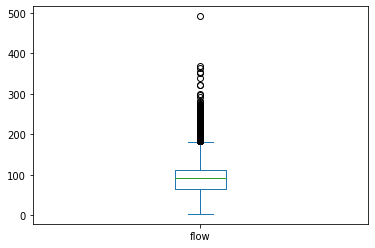

In [9]:
df.query('0 < flow < 500').flow.plot.box()

`-` 100,000을 넘기는 매우 큰 값이 존재한다

`-` 또한, 음수값도 존재하는데 이들은 모두 -100,000보다 작다

`-` 위와 같은 경우는 계측기에 문제가 있는 것으로 보인다

`-` 0인 경우도 존재한는데 계측기의 오류 또는 모종의 이유로 물이 흐르지 않은 것으로 보인다 (i.g. 배수지 청소로 인해 단수)

`-` 이런 경우 적산차값만 사용해 예측하는 것은 불가능하므로 이상치로 처리하겠다  

`-` 한편, 큰 양수의 경우 이상치의 기준은 300을 넘지 않는 값 중 최댓값으로 하겠다 (위의 box-plot에 기반함, IQR을 넘는 값들을 보면 300부터 절단되어 빈도수가 매우 작아짐)

`-` 이상치와 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 대체하겠다

In [10]:
def fillna(time_series: pd.Series, m: int = 24) -> pd.Series:
    """m 시점 앞의 값으로 결측치를 재귀적으로 채우고 데이터를 반환"""
    assert time_series.ndim == 1
    time_series = time_series.copy()  # 원본이 변하지 않도록 복제 
    na_idx = time_series[time_series.isnull()].index.values
    fill_idx = na_idx - m  # m 시점 앞의 값으로 결측치를 채운다
    fill_idx = np.where(fill_idx < 0, fill_idx + m, fill_idx)

    if not na_idx.size:                  # 결측치가 존재하지 않으면 원본을 반환
        return time_series
    if np.in1d(fill_idx, na_idx).all():  # m 시점 앞의 값이 결측치면 원본을 반환
        return time_series

    time_series[na_idx] = time_series[fill_idx]
    return fillna(time_series, m)

In [11]:
# 이상치는 결측치로 처리한다
tmp = df.flow[df.flow < 300].max()
df['flow'] = df['flow'].apply(lambda x: x if 0 < x <= tmp else np.nan)
test2['flow'] = test2['flow'].apply(lambda x: x if 0 < x <= tmp else np.nan)

In [12]:
# 결측치는 계절성을 고려하여 전날 같은 시각의 적산차값으로 채운다 
df['flow'] = fillna(df['flow']).fillna(method='ffill').fillna(0)
test2['flow'] = fillna(test2['flow']).fillna(method='ffill').fillna(0)

## 시각화

In [13]:
sns.set_theme(style='white')

In [14]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).\
groupby('year').flow.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2017,8759.0,94.024775,39.571984,3.0,66.0,89.0,115.0,273.0
2018,8760.0,102.328196,48.151006,4.0,68.0,93.0,113.0,296.0
2019,8760.0,98.975000,48.606899,15.0,63.0,91.0,109.0,283.0
2020,8784.0,101.714253,49.576752,4.0,64.0,94.0,113.0,273.0


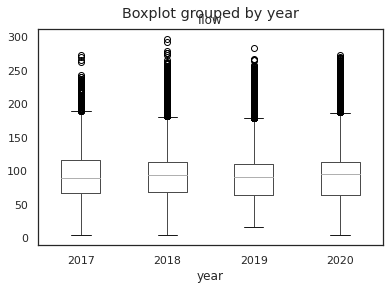

In [15]:
# 연도별 적산차의 분포
df.assign(year = df.datetime.dt.year).boxplot(column='flow', by='year', grid=False)

`-` 적산차의 경우 2017년과 나머지 연도는 다른 분포를 띄고있다 (평균과 분산이 더 커졌다)

`-` 원인은 200을 넘어가는 큰 값의 빈도수에 있다 (배수지를 증설한 듯 하다)

`-` 모델 훈련에 2017년 데이터를 사용하지 않는게 미래를 예측하는데 더 나을 수 있다

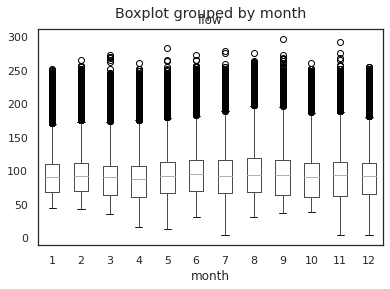

In [16]:
# 월별 적산차의 분포
df.assign(month = df.datetime.dt.month).boxplot(column='flow', by='month', grid=False)

`-` 8월의 수돗물 수요가 평균적으로 가장 많다

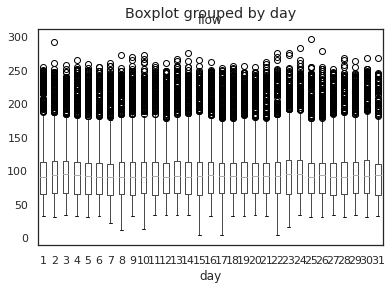

In [17]:
# 일별 적산차의 분포
df.assign(day = df.datetime.dt.day).boxplot(column='flow', by='day', grid=False)

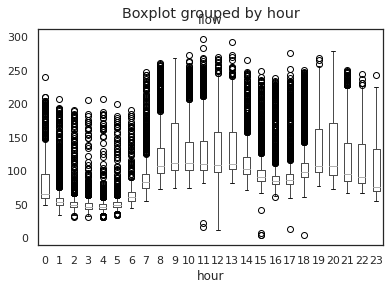

In [18]:
# 시간별 적산차의 분포
df.assign(hour = df.datetime.dt.hour).boxplot(column='flow', by='hour', grid=False)

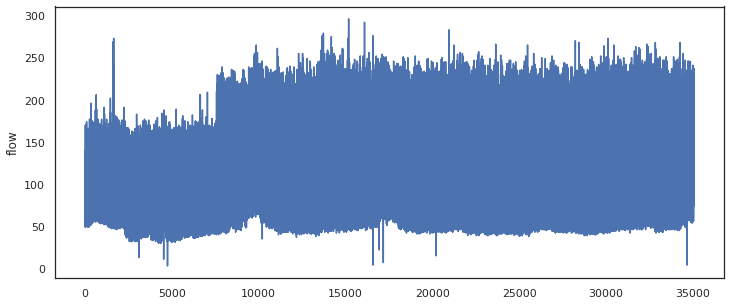

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=df['flow'], ax=ax)

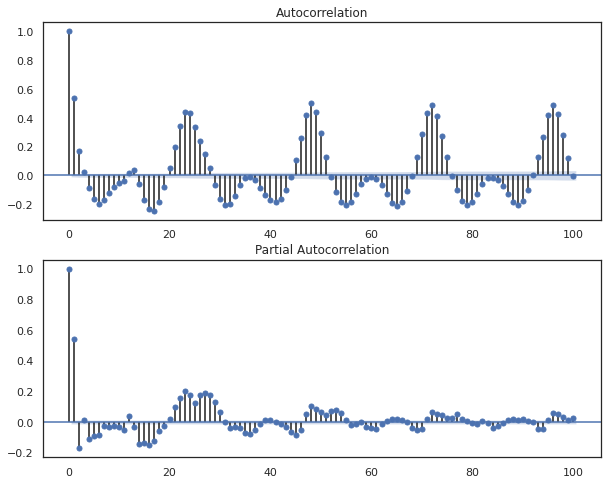

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
sgt.plot_acf(df['flow'], lags = 100, ax=ax1);
sgt.plot_pacf(df['flow'], lags = 100, ax=ax2);

`-` 그래프에 2017년을 제외하면 추세는 존재하지 않고 강한 계절성이 존재한다

`-` ACF, PACF의 정의에 따라 0시점 차이는 의미가 없으므로 무시한다

`-` 계절성이 매우 강하다 (6시간, 18시간, 24시간, 1주, 1달, 1년 등)

`-` 신기한 것은 12시점(12시간)차이의 경우 자기상관이 존재하지 않는다

`-` 사이클(W 모양)이 대략 24시간 마다 반복되므로 최소 24시간 분량의 변수를 모델의 입력으로 사용해야 한다

- 추가 설명

`-`  hello 라는 단어를 생각해보자, 다음의 같은 사이클이 반복된다

`-` h $\to$ e, e $\to$ l, l $\to$ l, l $\to$ o, o $\to$ h 

`-` 만약 단어 하나만이 입력으로 주어진다면 l이 입력으로 들어왔을 때 다음에 오는 단어가 l인지 o인지 알 수 없다

`-` 하지만 연속된 단어 두개가 입력으로 주어진다면 다음에 올 단어를 예측할 수 있다

`-` 예컨대 ll 이면 o, lo 이면 h이다

`-` 이는 적산차를 예측하는 문제에서도 마찬가지이다

- 고점 판단

`-` 시각화하면 알 수 있는데 고점은 하루에 2번 나타난다 (9시 부근, 20시 부근, 나머지는 잡음으로 생각)

In [21]:
high_value = np.quantile(df['flow'].values, q=1-2/24)  # 하루에 고점은 2번 (시각화로 확인함)

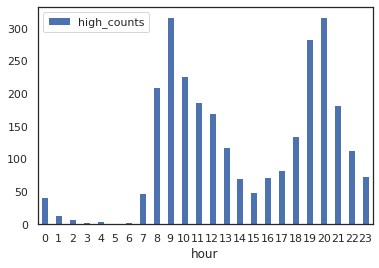

In [22]:
df.assign(year = df.datetime.dt.year).query('year > 2017').\
assign(is_high = (df.flow > high_value).astype(int)).\
assign(hour = df.datetime.dt.hour).\
groupby('hour').agg(high_counts=('is_high', np.sum)).\
reset_index().plot.bar(x='hour', y='high_counts', rot=0)

`-` 모델 학습에서 가장 큰 문제점은 고점이 언제인지 판단하는 것이다

`-` 고점이 언제 나타날지 불명확하기에 맞추기 어렵다

`-` 고점을 틀렸을 때 손실을 생각하면 맞추지 않는게 낫기에 모델은 고점을 전혀 잡아내지 못한다

`-` 즉, 모델은 고점을 잡음으로 취급한다

## 딥러닝 모델 학습

In [23]:
!git clone https://github.com/ts-kim/RevIN.git

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer
from torch.autograd import Variable

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from RevIN.RevIN import RevIN

- base score

In [31]:
tmp = df['flow'].values
m = 48
mean_absolute_error(tmp[m:], tmp[:-m])

26.555818934742252

In [32]:
mean_absolute_error(df['flow'].values[m:], df['flow'].ewm(span=2).mean().values[:-m])

25.772675330276037

- 학습 방법

`-` private 데이터는 2022-01-01-00:00:00 부터 존재할 것이다

`-` public 데이터는 2021-12-17 23:00:00 까지 존재한다

`-` 2021-12-17 23:00:00 에서 337시간 뒤는 2022-01-01 00:00:00 이다

`-` 337시간 후의 적산차를 예측하는 모델을 만드는게 적합하지만 그러면 시간상의 차이가 많이 나서 성능이 떨어진다

`-` 따라서 1시간 후의 적산차를 예측하는 모델을 만들고 존재하지 않는 시각의 정보는 예측한 정보로 대체하여 사용하겠다

`-` 1시간 후의 적산차를 예측하기 위해 pacf 그래프에 근거해 24시간의 배수에 해당하는 분량을 사용하겠다

`-` 사이클을 포함하는(24시간 이상) 시계열 중 24시간 차이가 나는 데이터간의 직접적인 상관관계가 가장 크다

`-` 하나의 사이클을 포함하면서 과적합을 피하기 위해 24*n 시간 분량을 사용하겠다

- 전처리

In [33]:
def ts_train2supervised(
    ts: NDArray[np.float_], 
    window: int = 24,
    gap: int = 1, 
    step: int = 336
) -> Tuple[NDArray[np.float_], NDArray[np.float_]]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X, y = [], []
    for t in range(len(ts) - (window+gap+step) + 2):
        X.append(ts[t:t+window])
        y.append(ts[t+window+gap-1 : t+window+gap+step-1])
    X, y = np.array(X), np.array(y)  
    return X, y

`-` 예측을 위해 train과 test를 병합 

In [34]:
def ts_test2supervised(
    ts: NDArray[np.float_], 
    window: int = 24
) -> NDArray[np.float_]:
    assert ts.ndim == 2 and ts.shape[1] == 1
    X = []
    for t in range(len(ts) - window + 1):
        X.append(ts[t:t+window])
    X = np.array(X)
    return X

- 난수 고정, gpu 설정

In [35]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

In [36]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

In [37]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {DEVICE}입니다')

현재 device는 cuda입니다


- 피쳐 스케일링

`-` 0 ~ 1 사이로 정규화

`-` 2017년은 빼고하는 것이 합리적이지만 2017년 데이터는 최댓값, 최솟값에 영향을 주지 않으므로 괜찮다

In [38]:
minmax_scaler = MinMaxScaler()
flow_scaled = minmax_scaler.fit_transform(df['flow'].values.reshape(-1, 1))  
flow_scaled_test = minmax_scaler.transform(test2['flow'].values.reshape(-1, 1))   

- 데이터 셋과 데이터 로더

In [39]:
class CustomDataset(Dataset):
    def __init__(self, X: NDArray[np.float_], y: Optional[NDArray[np.float_]] = None) -> None:
        super(CustomDataset, self).__init__()
        self.X = X
        self.y = y

    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor], Tensor]:
        X = torch.FloatTensor(self.X[idx])
        if self.y is not None:
            y = torch.FloatTensor(self.y[idx])
            return X, y
        return X

    def __len__(self) -> int:
        return self.X.shape[0]

In [40]:
def get_dataloader(
    X: NDArray[np.float_], 
    y: Optional[NDArray[np.float_]] = None, 
    batch_size: int = 64, 
    shuffle: bool = True
) -> DataLoader:
    dataset = CustomDataset(X, y)    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

- early stopping

In [41]:
# ref: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
        'accuracy',
        'f1_score',
        'mae',
    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        folder_path: str = './weights', 
        model_name: str = '',
    ) -> None:
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  # 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.folder_path = folder_path    
        self.model_name = model_name
        self.reset_fold()  # for k-fold cross validation

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        # score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        # score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  # 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  # score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path) 
        self.valid_loss = valid_loss  # 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  # 이때의 valid metric score도 변경

    @property
    def path(self) -> str:
        return f'{self.folder_path}/{self.model_name}_best_{self.fold}.pt'

    def reset_fold(self) -> None:
        self.fold = 0

    def update_fold(self) -> None:
        self.fold += 1

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

- 손실 함수

In [42]:
loss_fn = nn.L1Loss()

- 학습 및 검증

In [44]:
def train(
    model: nn.Module,
    dataloader: DataLoader, 
    device: torch.device,
    loss_fn: _Loss, 
    optimizer: Optimizer, 
    scaler: torch.cuda.amp.GradScaler,
    args: EasyDict,
    scheduler: Optional[_LRScheduler] = None
) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0
    model.to(device)
    model.train()

    for X, y in dataloader:  
        X, y = X.to(device), y.to(device) 
        with torch.cuda.amp.autocast():
            y_hat = model(X)
            loss = loss_fn(y_hat, y)  

        optimizer.zero_grad()  
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.max_norm)
        scaler.step(optimizer)
        scaler.update()
        train_loss += (loss.item() / len(dataloader)) 
  
    # 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()
        
    return model, train_loss

In [45]:
def evaluate(
    model: nn.Module, 
    dataloader: DataLoader, 
    device: torch.device,
    loss_fn: _Loss,
    args: EasyDict
) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 ACD f1 score를 반환"""
    valid_loss = 0.0
    y_list, yhat_list = np.array([]).reshape(0, args.num_classes), np.array([]).reshape(0, args.num_classes)
    model.to(device)
    model.eval()  

    with torch.no_grad():  
        for X, y in dataloader:  
            X, y = X.to(device), y.to(device) 
            with torch.cuda.amp.autocast():
                y_hat = model(X)
                loss = loss_fn(y_hat, y)
                  
            y = y.detach().cpu().numpy()  # y shape: (B, 336)
            y_hat = y_hat.detach().cpu().numpy()  # yhat shape: (B, 336)
            y_list = np.concatenate([y_list, minmax_scaler.inverse_transform(y)])
            yhat_list = np.concatenate([yhat_list, minmax_scaler.inverse_transform(y_hat)])
            valid_loss += (loss.item() / len(dataloader))

    valid_mae = mean_absolute_error(y_list, yhat_list)        
    return valid_loss, valid_mae

In [46]:
def kfold_cross_validate(
    model: nn.Module, 
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    loss_fn: _Loss, 
    early_stopping: EarlyStopping,
    device: torch.device,
    args: EasyDict 
) -> Tuple[nn.Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 검증 손실을 반환"""
    seed_everything(args.seed)   # 정확한 재현을 위함
    fold_valid_loss = []         # 폴드별 best 검증 손실
    fold_valid_mae = []          # 폴드별 best 검증 MAE
    fold_train_losses_per_epoch = [[] for _ in range(args.num_folds)]  # 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[] for _ in range(args.num_folds)]  # 폴드별 1 에폭에 따른 검증 배치 손실
    early_stopping.reset_fold()  # 폴드 순서 0 번째로 초기화
    tscv = TimeSeriesSplit(n_splits=args.num_folds)     

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f'[{fold + 1} / {args.num_folds}] Fold Training......')

        # 메모리 절약
        clear_gpu()

        # 훈련 데이터와 검증 데이터로 분할
        X_train, y_train = X[train_idx], y[train_idx] 
        X_val, y_val =  X[val_idx], y[val_idx]

        # Dataloader
        train_dataloader = get_dataloader(X_train, y_train, args.bs)
        valid_dataloader = get_dataloader(X_val, y_val, args.bs, shuffle=False)

        # optimizer
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay) 

        # scheduler
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_gamma)

        # grad scalder
        scaler = torch.cuda.amp.GradScaler()

        # early stopping, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.update_fold()  
        
        # 폴드마다 모델 학습
        for epoch in tqdm(range(1, args.num_epochs+1)):  # (배치사이즈 X 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, device, loss_fn, optimizer, scaler, args, scheduler)  # 모델 학습
            valid_loss, valid_mae = evaluate(model, valid_dataloader, device, loss_fn, args)  # 모델 평가
            fold_train_losses_per_epoch[fold].append(train_loss) 
            fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 10 == 0 or epoch == args.num_epochs)  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid MAE = {valid_mae:.5f}'

            # 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            # 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_mae)  
            if early_stopping.early_stop: 
                if not print_score_condition:  # 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_loss.append(early_stopping.valid_loss)  # 폴드별 best 검증 손실
        fold_valid_mae.append(early_stopping.valid_metric_score)   # 폴드별 best 검증 MAE

        # 폴드 학습 및 검증 종료시 가장 작은 검증 손실과 매트릭 스코어를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid MAE: {early_stopping.valid_metric_score:.5f}', end='\n\n')
      
    ## 폴드별 가장 손실이 작은 모델의 평균 검증 손실과 이때의 평균 매트릭 스코어를 출력
    print(f'{args.num_folds} Fold Mean Valid Best Loss: {np.mean(fold_valid_loss):.5f}')
    print(f'{args.num_folds} Fold Mean Valid Accuracy: {np.mean(fold_valid_mae):.5f}')
    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 에폭에 따른 손실의 변화

In [47]:
def show_loss_plot(
    fold_train_losses: List[List[float]],
    fold_valid_losses: List[List[float]]
) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    # 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    # 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

- Test 예측

In [49]:
def predict(
    model: nn.Module, 
    X: NDArray[np.float_],
    device: torch.device,
    args: EasyDict
) -> Tensor:   
    weight_paths = glob(args.weight_folder_path + '/*.pt')
    dataloader = get_dataloader(X, shuffle=False)
    test_preds = torch.zeros(len(dataloader.dataset), args.num_classes)  
    num_folds = len([weight_path for weight_path in weight_paths if args.model_name in weight_path])
     
    for weight_path in tqdm(weight_paths):
        if args.model_name not in weight_path:
            continue
            
        preds = np.array([]).reshape(0, args.num_classes)
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.to(device)
        model.eval()

        with torch.no_grad(): 
            for X in dataloader:  # test 데이터는 라벨(y)이 없다
                X = X.to(device)  # shape of X: (Batch, Sequence, Feature)
                y_hat = model(X).detach().cpu().numpy()  # shape of yhat: (Batch, Class)
                preds = np.concatenate([preds, y_hat]) 

        test_preds += (preds / num_folds) 
    return test_preds     

- 후처리

`-` 훈련 데이터를 보면 적산차값이 모두 정수형이다

`-` 예측값도 반올림하여 정수로 만들어주겠다

`-` 최솟값과 최댓값을 제한

In [50]:
MAX = df['flow'].values.max()
MIN = df['flow'].values.min()

In [51]:
def postprocessing(pred: NDArray[np.float_], minimum: float, maximum: float) -> NDArray[np.float_]:
    pred = np.clip(pred, minimum, maximum)
    pred = np.round(pred)
    return pred

### LSTM 모델 학습

#### 모델 학습 준비

In [82]:
lstm_args = EasyDict({
    'weight_folder_path':'./weights',
    'model_name':'lstm',
    'window':96,
    'gap':1,
    'num_classes':336,
    'num_epochs':200,
    'num_folds':5,
    'bs':512,
    'lr':2e-3,
    'lr_gamma':0.965,
    'weight_decay':1e-2,
    'max_norm':1.0,
    'seed':2022,
})

In [53]:
create_folder(lstm_args.weight_folder_path)

- 데이터 생성

In [54]:
Xs, ys = ts_train2supervised(flow_scaled, window=lstm_args.window, gap=lstm_args.gap, step=lstm_args.num_classes)  # s == scaled
Xs, ys = Xs[24*365:], ys[24*365:]  # 2017년 제거
ys = ys.squeeze(2)

#### 모델 학습 및 검증

In [55]:
# 참고: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
# 참고할 것: https://teddylee777.github.io/pytorch/pytorch-rnn
# input of shape (batch, sequence, feature(=input size)) 
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=4, num_classes=336, dropout_prob=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.revin_layer = RevIN(input_size)  # 시간에 따라 변하는 시계열의 평균과 분산을 스케일링

    def forward(self, x):  # shape of x: (Batch, Sequence, Feature)
        x = self.revin_layer(x, 'norm')
        x, _ = self.lstm(x)  # h_0, c_0 기본값은 0으로 채워진 텐서
        x = self.fc(x[:, -1, :])  
        x = x.unsqueeze(2)
        x = self.revin_layer(x, 'denorm')
        x = x.squeeze(2)
        return x

In [83]:
early_stopping = EarlyStopping(patience=20,
                               monitor='mae',
                               mode='min',
                               folder_path=lstm_args.weight_folder_path,
                               model_name=lstm_args.model_name)

In [84]:
seed_everything(lstm_args.seed)
model = LSTMModel(input_size=1, hidden_size=512, num_layers=2, num_classes=lstm_args.num_classes, dropout_prob=0.5).to(DEVICE)

In [85]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, Xs, ys, loss_fn, 
                                                                                       early_stopping, DEVICE, lstm_args)

[1 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11295  valid loss = 0.11921  valid MAE = 35.18269
[Epoch: 10]  train loss = 0.07870  valid loss = 0.07987  valid MAE = 23.51748
[Epoch: 20]  train loss = 0.07574  valid loss = 0.07727  valid MAE = 22.69758
[Epoch: 30]  train loss = 0.07452  valid loss = 0.07658  valid MAE = 22.48942
[Epoch: 40]  train loss = 0.07418  valid loss = 0.07593  valid MAE = 22.29907
[Epoch: 50]  train loss = 0.07380  valid loss = 0.07567  valid MAE = 22.22796
[Epoch: 60]  train loss = 0.07348  valid loss = 0.07524  valid MAE = 22.11024
[Epoch: 70]  train loss = 0.07317  valid loss = 0.07527  valid MAE = 22.12504
[Epoch: 80]  train loss = 0.07272  valid loss = 0.07604  valid MAE = 22.36319
[Epoch: 84]  train loss = 0.07256  valid loss = 0.07615  valid MAE = 22.39477
Early Stopping!
1 Fold -> Best Valid Loss: 0.07520 Valid MAE: 22.09275

[2 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.10624  valid loss = 0.08331  valid MAE = 24.24710
[Epoch: 10]  train loss = 0.07551  valid loss = 0.07355  valid MAE = 21.41071
[Epoch: 20]  train loss = 0.07464  valid loss = 0.07135  valid MAE = 20.74943
[Epoch: 30]  train loss = 0.07375  valid loss = 0.07039  valid MAE = 20.51683
[Epoch: 40]  train loss = 0.07300  valid loss = 0.06992  valid MAE = 20.39977
[Epoch: 50]  train loss = 0.07224  valid loss = 0.07002  valid MAE = 20.43735
[Epoch: 60]  train loss = 0.07153  valid loss = 0.07051  valid MAE = 20.57359
[Epoch: 68]  train loss = 0.07116  valid loss = 0.07000  valid MAE = 20.41700
Early Stopping!
2 Fold -> Best Valid Loss: 0.06973 Valid MAE: 20.34029

[3 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11426  valid loss = 0.10084  valid MAE = 29.75482
[Epoch: 10]  train loss = 0.07446  valid loss = 0.07611  valid MAE = 22.41924
[Epoch: 20]  train loss = 0.07321  valid loss = 0.07458  valid MAE = 21.95659
[Epoch: 30]  train loss = 0.07223  valid loss = 0.07354  valid MAE = 21.65809
[Epoch: 40]  train loss = 0.07178  valid loss = 0.07384  valid MAE = 21.74023
[Epoch: 50]  train loss = 0.07105  valid loss = 0.07385  valid MAE = 21.75201
[Epoch: 60]  train loss = 0.07059  valid loss = 0.07363  valid MAE = 21.67616
[Epoch: 70]  train loss = 0.07019  valid loss = 0.07363  valid MAE = 21.68042
[Epoch: 73]  train loss = 0.07006  valid loss = 0.07391  valid MAE = 21.76437
Early Stopping!
3 Fold -> Best Valid Loss: 0.07337 Valid MAE: 21.60208

[4 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.10261  valid loss = 0.08999  valid MAE = 26.39280
[Epoch: 10]  train loss = 0.07378  valid loss = 0.07621  valid MAE = 22.32692
[Epoch: 20]  train loss = 0.07247  valid loss = 0.07760  valid MAE = 22.74879
[Epoch: 30]  train loss = 0.07141  valid loss = 0.07461  valid MAE = 21.86211
[Epoch: 40]  train loss = 0.07081  valid loss = 0.07450  valid MAE = 21.79927
[Epoch: 50]  train loss = 0.06996  valid loss = 0.07464  valid MAE = 21.83670
[Epoch: 60]  train loss = 0.06946  valid loss = 0.07456  valid MAE = 21.81231
[Epoch: 66]  train loss = 0.06925  valid loss = 0.07458  valid MAE = 21.82008
Early Stopping!
4 Fold -> Best Valid Loss: 0.07438 Valid MAE: 21.77204

[5 / 5] Fold Training......


  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.07848  valid loss = 0.07503  valid MAE = 21.95615
[Epoch: 10]  train loss = 0.07138  valid loss = 0.07433  valid MAE = 21.79656
[Epoch: 20]  train loss = 0.06969  valid loss = 0.07403  valid MAE = 21.71082
[Epoch: 30]  train loss = 0.06879  valid loss = 0.07434  valid MAE = 21.81018
[Epoch: 40]  train loss = 0.06812  valid loss = 0.07418  valid MAE = 21.74858
[Epoch: 43]  train loss = 0.06790  valid loss = 0.07429  valid MAE = 21.77502
Early Stopping!
5 Fold -> Best Valid Loss: 0.07395 Valid MAE: 21.70009

5 Fold Mean Valid Best Loss: 0.07333
5 Fold Mean Valid Accuracy: 21.50145


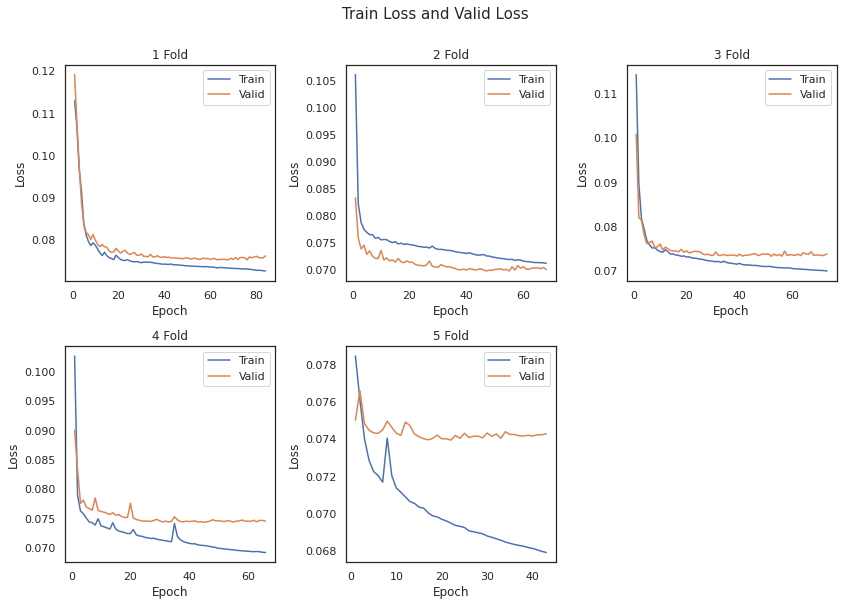

In [86]:
show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)  

#### Test 예측

In [87]:
flow_scaled_all = np.concatenate([flow_scaled[-lstm_args.window:], flow_scaled_test])  # train + test
Xs_test = ts_test2supervised(flow_scaled_all, window=lstm_args.window)   

In [88]:
preds = predict(model, Xs_test, DEVICE, lstm_args)

  0%|          | 0/5 [00:00<?, ?it/s]

In [89]:
preds = minmax_scaler.inverse_transform(preds)
submission.loc[:, 'h0':'h335'] = postprocessing(preds, MIN, MAX)
submission.to_csv(f'./data/submission_apo_{lstm_args.model_name}.csv', index=False)

- 성능 확인

In [90]:
tmp = test.copy()
for w in range(1, 336):
    tmp[f'flow{w}'] = tmp['flow'].shift(-w)

y_hat = submission.loc[:, 'h0':'h335'].to_numpy()[:8089]
tmp = tmp.dropna().loc[:, 'flow':'flow335'].to_numpy()
mean_absolute_error(tmp, y_hat)

22.005762896702752

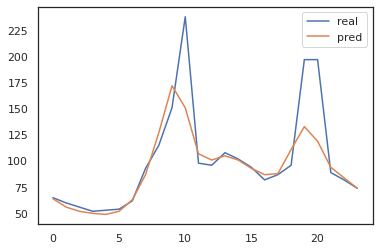

In [105]:
idx = 24*102
plt.plot(tmp[idx][:24], label='real')
plt.plot(submission.loc[idx, 'h0':'h335'].values[:24], label='pred')
plt.legend()